In [1]:
import numpy
from scipy import integrate
%pylab inline
from galpy.util import bovy_plot
import seaborn as sns
from matplotlib import ticker
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=14.,xtick_labelsize=16.,ytick_labelsize=16.)

Populating the interactive namespace from numpy and matplotlib


# The Milky Way's subhalo mass function

## The classical dwarfs

We get the high-mass end by using the classical dwarfs, for which observations are complete out to 300 kpc:

In [2]:
# From Garrison-Kimmel et al. (2017)
sats= ['LMC','SMC','Sgr','Fornax','LeoI','Sculptor','LeoII','Sextans','Carina','Ursa Minor','Draco']
stellarmass= numpy.array([1.06*10.**9,3.69*10.**8.,3.44*10.**7.,3.25*10.**7.,8.79*10.**6.,3.67*10.**6.,
                         1.18*10.**6.,6.98*10.**5.,6.03*10.**5.,4.53*10.**5.,4.53*10.**5.])

We assign a halo mass using a stellar-mass--halo-mass relation:

In [3]:
# Stellar-mass --> halo-mass from Bullock & Boylan-Kolchin (2017) [refer to Behroozi in prep.?]
def halo_mass(stellar_mass):
    return 10**(1./numpy.log10(300/2.2)*(numpy.log10(stellar_mass)-numpy.log10(3)-8)+11.)
halomass= halo_mass(stellarmass)

This gives the following:

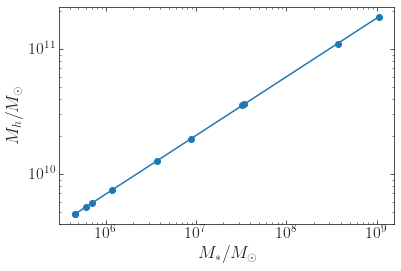

In [4]:
loglog(stellarmass,halo_mass(stellarmass),'o-')
xlabel(r'$M_*/M_\odot$')
ylabel(r'$M_h/M_\odot$');

Later we will extrapolate our measurements from the inner halo to the 300 kpc volume by assuming the Einasto spatial profile:

In [5]:
def spatial_profile(r,alpha=0.678,rm2=162.4):
    # Einasto, r in kpc
    return numpy.exp(-2./alpha*((r/rm2)**alpha-1.))

In [6]:
observed_volume= 23. # kpc
scale_to_300kpc= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]\
                    /integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,observed_volume)[0]

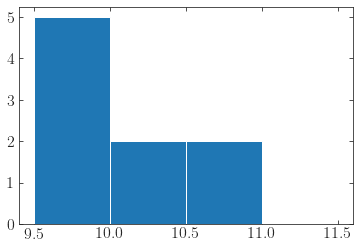

In [7]:
# Don't consider LMC/SMC
num_sats,e,_=hist(numpy.log10(halomass)[2:],range=[9.5,11.5],bins=4);
mass_bins= 10.**((numpy.roll(e,1)+e)[1:]/2.)

In [8]:
mass_bins, num_sats

(array([5.62341325e+09, 1.77827941e+10, 5.62341325e+10, 1.77827941e+11]),
 array([5., 2., 2., 0.]))

## Our dark subhalo measurements

Then we add our dark subhalo measurements. Here I will just assume that what we measure is exactly the fiducial rate, but these could easily be replaced by our actual measurements (+errorbars).

The following are a bunch of functions to compute our fiducial rate:

In [9]:
def mass_function(m,c0=2.02*1e-13,m0=2.52*1e7):
    return c0*(m/m0)**-1.9

In [10]:
low_mass_bins_e= [10.**5,10.**6.,10.**7.,10.**8.,10.**9.]
low_mass_bins= 10.**((numpy.roll(numpy.log10(low_mass_bins_e),1)+numpy.log10(low_mass_bins_e))[1:]/2.)

The following is the number of subhalos for ``rate=1``:

In [11]:
num_subs_cdm= numpy.array([integrate.quad(lambda m: mass_function(m),low_mass_bins_e[ii],low_mass_bins_e[ii+1])[0]\
              *integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,observed_volume)[0]
          for ii in range(len(low_mass_bins))])

The actual measured number is relative to this

In [12]:
num_subs_obs= numpy.array([numpy.nan,numpy.nan,0.2,0.2])
num_subs_obs_err_up= numpy.array([numpy.nan,numpy.nan,0.7,0.5])
num_subs_obs_err_lo= numpy.array([numpy.nan,numpy.nan,0.1,0.1])
num_subs_up_lim= numpy.array([6.,3.6,numpy.nan,numpy.nan])

Now we combine everything:

In [13]:
def plot_massfunction(add_mwdm=False,savefilename=None):
    color_us= sns.color_palette("Paired")[1]
    bovy_plot.bovy_plot(low_mass_bins,num_subs_obs*num_subs_cdm*scale_to_300kpc,
                        marker='o',loglog=True,color=color_us,ls='none',
                        xlabel=r'$M_h/M_\odot$',ylabel=r'$dN/d\log_{10} M$',
                       xrange=[3e4,1e12],yrange=[8e-2,4e5])
    line_us= errorbar(low_mass_bins,num_subs_obs*num_subs_cdm*scale_to_300kpc,
                      yerr=[num_subs_obs_err_lo*num_subs_cdm*scale_to_300kpc,
                      num_subs_obs_err_up*num_subs_cdm*scale_to_300kpc],
                      marker='o',ls='none',color=color_us,ms=8.,mew=2.,
                     label=r'$\mathrm{Streams}\,(\mathrm{Banik\ et\ al.\,2019;\, this\ paper)}$')
    errorbar(low_mass_bins,num_subs_up_lim*num_subs_cdm*scale_to_300kpc,
             yerr=num_subs_up_lim*num_subs_cdm*scale_to_300kpc/2.01,
             uplims=True,mew=2.,
             marker='_',ls='none',color=color_us,ms=10.)
    line_sats= errorbar(mass_bins,num_sats,yerr=numpy.sqrt(num_sats),
                        marker='*',ls='none',color=sns.color_palette("Paired")[5],ms=12.,
                        label=r'$\mathrm{Classical\ MW\ satellites}$')
    # Prediction
    pred_ms= 10.**numpy.linspace(5.,11.5,11)
    mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
    prediction_cdm= numpy.array([integrate.quad(lambda m: mass_function(m),
                                            pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                                 *mwvol for ii in range(len(pred_ms))])
    line_pred_cdm= loglog(pred_ms,prediction_cdm,lw=2.,color='k',
                          label=r'$\mathrm{DM\ only}$')
    low_indx= pred_ms < 1e9
    line_pred= fill_between(pred_ms[low_indx],
                            0.1*prediction_cdm[low_indx],0.5*prediction_cdm[low_indx],
                            color='0.75',
                           label=r'$\mathrm{incl.\ baryonic\, disruption}$')
    l1= legend(handles=[line_us,line_sats],
           framealpha=1.,facecolor='w',edgecolor='none',
           fontsize=17.,loc='lower left',frameon=False)
    l2= legend(handles=[line_pred_cdm[0],line_pred],
           framealpha=1.,facecolor='w',edgecolor='none',
           fontsize=17.,loc='upper right',frameon=False)
    gca().add_artist(l1)
    gca().add_artist(l2)
    if add_mwdm:
        def mhalo_to_mwdm(mh):
            return 3.3*(mh/3e8)**-0.3
        minM,maxM= gca().get_xlim()
        ax2= gca().twiny()
        ax2.set_xlim(mhalo_to_mwdm(minM),mhalo_to_mwdm(maxM))
        ax2.set_xlabel(r'$m_{\mathrm{WDM}}/\mathrm{keV}$')
        ax2.set_xscale('log')
        ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter(r'$%0.f$'))
    if not savefilename is None:
        bovy_plot.bovy_end_print(savefilename)

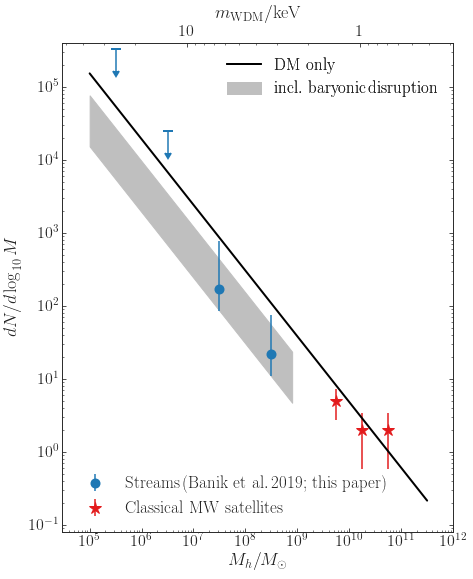

In [14]:
figsize(7,9)
plot_massfunction(add_mwdm=True)#,savefilename='subhalo_massfunction.pdf')